In [1]:
import shutil
from pathlib import Path
import json
from tqdm import tqdm

import torch
import nibabel as nib

from slice_inflate.datasets.clinical_cardiac_views import get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines
from slice_inflate.utils.nifti_utils import crop_around_label_center

In [2]:
C3D = "/home/weihsbach/storage/staff/christianweihsbach/c3d/c3d-1.4.0-Linux-gcc64/bin/c3d"
MMWHS_BASE_PATH = "../../data/datasets/MMWHS"


test_cases = [1007,1008] # These look very strange. better to exclude them -> perform 3-fold cross-validation
train_cases = set(range(1001,1021)) - set(test_cases)
train_cases = list(train_cases)
NUM_FOLDS = 3

assert Path(MMWHS_BASE_PATH).is_dir()

split_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/data_split.json')
split_file_path.parent.mkdir(exist_ok=True, parents=True)
metadata_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/metadata.json')

# Split dataset

In [3]:
if False:
    # Copy the files
    base_ct_paths = list(Path(MMWHS_BASE_PATH, 'base_files/ct_train').glob('*.nii.gz'))
    base_mr_paths = list(Path(MMWHS_BASE_PATH, 'base_files/mr_train').glob('*.nii.gz'))

    # base_paths = base_ct_paths + base_mr_paths
    base_paths = base_mr_paths

    for p in tqdm(base_paths):
        dest_path = Path(MMWHS_BASE_PATH, 'prepared_files', p.name)
        dest_path.parent.mkdir(exist_ok=True)
        tqdm.write(f"{p} -> {dest_path}")
        shutil.copy(p, dest_path)

if False:
    # Split the copied files
    def get_fold_idxs_dict(paths):
        paths = sorted(paths)
        img_idxs = torch.arange(len(paths))[::2] # Every second path is an image

        cnks = torch.stack(torch.chunk(img_idxs, NUM_FOLDS))
        folds = []
        for f_idx in range(NUM_FOLDS):
            val_idxs = cnks.roll(f_idx, dims=0)[0]
            train_idxs = cnks.roll(f_idx, dims=0)[1:].flatten()
            folds.append((train_idxs, val_idxs))

        fold_dct = dict()
        for idx,f in enumerate(folds):
            train_idxs = sorted(f[0].tolist() + (f[0]+1).tolist())
            val_idxs = sorted(f[1].tolist() + (f[1]+1).tolist())
            fold_dct[f"fold_{idx}"] = dict(train_idxs=train_idxs, val_idxs=val_idxs)
        return fold_dct

    prepared_paths = list(Path(MMWHS_BASE_PATH, 'prepared_files').resolve().glob('*.nii.gz'))
    train_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in train_cases]), prepared_paths))
    test_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in test_cases]), prepared_paths))

    split_dict = dict(
        train_files=[str(p) for p in train_paths],
        train_folds=get_fold_idxs_dict(train_paths),
        test_files=[str(p) for p in test_paths]
    )

    with open(split_file_path, 'w') as f:
        json.dump(split_dict, f, indent=4)

# Reorient MMWHS files to LPI

In [4]:
!{C3D} -version # We need at least v1.4.0

Convert3D Version 1.4.0
  Release date:      May 19, 2022
  Compile date:      Jan 13, 2023
  GIT branch:        master
  GIT commit:        feab59822240a870db021530cdb2b35dd582c871
  GIT commit date:   2022-12-20 17:21:09 -0500



In [5]:
if False:
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['train_files'] + split_dict['test_files']

    MMWHS_LABELS = (205,500,600,420,550) #MYO, LV, RV, LA, RA
    NEG_LABELS = (-1,-2,-3,-4,-5)
    TARGET_LABELS = (1,2,3,4,5)

    from itertools import chain, repeat

    for nii_path in tqdm(prepared_paths):
        tqdm.write(f"Processing {Path(nii_path).name}")
        if 'label' in str(nii_path):
            # Two step replacement to cut away all other classes
            neg_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(MMWHS_LABELS, NEG_LABELS))])
            target_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(NEG_LABELS, TARGET_LABELS))])
            command = \
                f"{C3D} {nii_path} " \
                f"-type int " \
                f"-interpolation NearestNeighbor -resample-mm 1x1x1mm " \
                f"-replace {neg_label_replace_str} " \
                f"-clip -inf 0 " \
                f"-replace {target_label_replace_str} " \
                f"-swapdim LPI -o {nii_path}"
            !{command}
        else:
            command = \
                f"{C3D} {nii_path} " \
                f"-type float " \
                f"-resample-mm 1x1x1mm " \
                f"-swapdim LPI -o {nii_path}"
            !{command}

# Extract clinical views

mr_train_1001_image


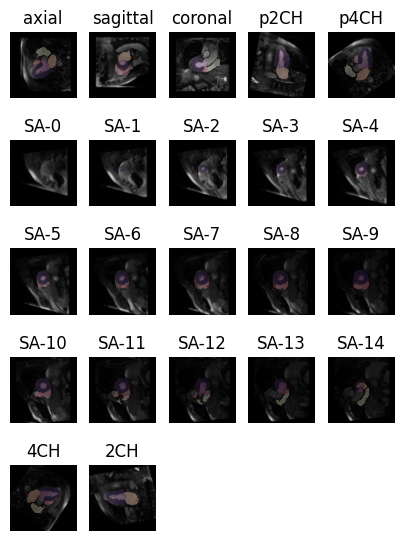



mr_train_1006_image


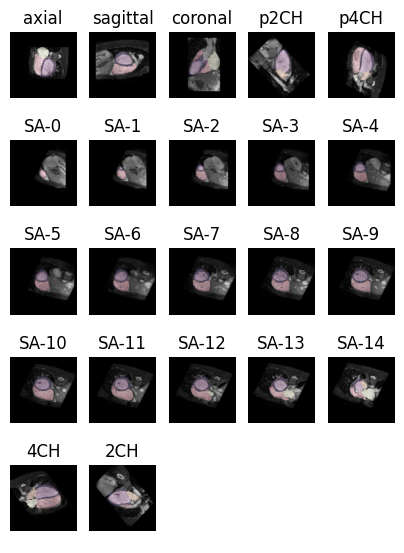



mr_train_1013_image


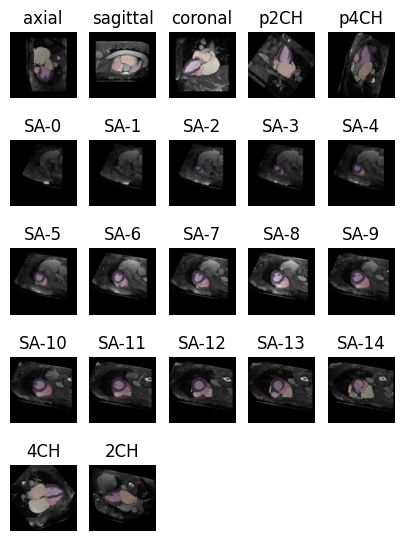



mr_train_1018_image


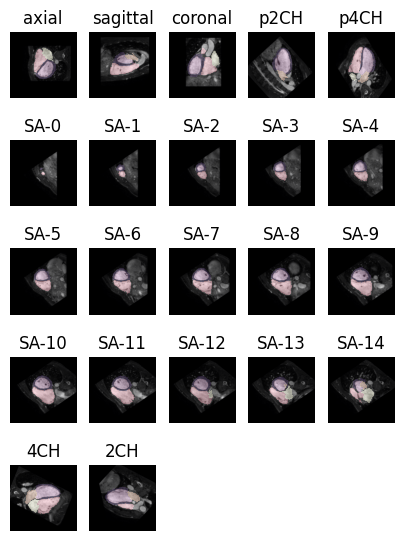

In [6]:
NUM_SA_SLICES = 15

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

with open(split_file_path, 'r') as f:
    split_dict = json.load(f)
prepared_paths = split_dict['train_files'] + split_dict['test_files']
metadata_dict = dict()

if False:
    # Crop the images
    FOV_MM = torch.tensor([240.,240.,240.])
    FOV_VOX = fov_vox=torch.tensor([160,160,160])

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())
        class_selected_sp_label = get_sub_sp_tensor(sp_label, eq_value=tuple(class_dict.values()))

        cropped_label, cropped_image, cropped_nii_affine = crop_around_label_center(
            class_selected_sp_label.to_dense()[None,None], volume_affine[None], fov_mm=FOV_MM, fov_vox=FOV_VOX,
            image=volume[None,None])

        nib.save(nib.Nifti1Image(cropped_label[0,0].int().numpy(), affine=cropped_nii_affine[0].numpy()), nii_label_path)
        nib.save(nib.Nifti1Image(cropped_image[0,0].numpy(), affine=cropped_nii_affine[0].numpy()), nii_image_path)

if True:
    display_idx = 0

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue
        # if ('mr_train_1015' not in nii_label_path) and ('mr_train_1002' not in nii_label_path): continue
        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())

        clinical_view_affines = get_clinical_cardiac_view_affines(
            sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, return_unrolled=True, debug=False
        )

        image_id = nii_image_path.split('/')[-1].replace('.nii.gz', '')
        metadata_dict[image_id] = dict(view_affines={name:affine.tolist() for name, affine in clinical_view_affines.items()})

        if display_idx % 5 == 0:
            # Print every 5th sample
            print(image_id)
            display_clinical_views(volume, sp_label, volume_affine, clinical_view_affines,
                # output_to_file=f'corrected_clinical_{image_id}.png'
            )
            print()
            print()

        display_idx +=1

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_dict, f, indent=4)